# ...

In this notebook, we use the Rosetta enzyme design feature set (47 features) to predict protein melting temperature (39 -/+ 8 C) for 68 samples. We use elastic net for simultaneous model fitting and feature selection

In [36]:
%matplotlib inline 

import pandas 
import matplotlib.pyplot as plt 
from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegressionCV

my_classifiers = []

In [37]:
df = pandas.read_csv( 'feature_sets/tm.csv', index_col=0 ) 
print df.sample( 5 ) 

        total_score   fa_rep  hbond_sc  tot_pstat_pm  tot_nlpstat_pm  \
mutant                                                                 
R240A      -686.951  284.914   -68.033         0.691           0.691   
W120F      -685.969  284.102   -68.952         0.690           0.686   
E177A      -687.185  286.028   -68.880         0.689           0.689   
L362M      -543.151  348.665   -69.725         0.704           0.695   
N404C      -687.356  287.140   -69.739         0.693           0.690   

        tot_burunsat_pm  tot_hbond_pm  tot_NLconts_pm  tot_nlsurfaceE_pm  \
mutant                                                                     
R240A             154.0         435.0           150.0              1.030   
W120F             153.1         435.3           150.0              0.979   
E177A             151.1         437.4           152.0              1.027   
L362M             151.3         438.5           151.4              0.906   
N404C             150.7         436.8  

In [38]:
expr_corr = df.corr()['tm']
print expr_corr.sort_values().head( 10 ) 
print expr_corr.sort_values().tail( 10 ) 

SR_5_fa_rep             -0.260434
tot_total_charge        -0.207763
SR_2_hbond_pm           -0.190429
SR_2_fa_rep             -0.166348
tot_nlsurfaceE_pm       -0.115038
tot_total_pos_charges   -0.114026
SR_1_nlpstat_pm         -0.103578
SR_3_nlpstat_pm         -0.103578
SR_2_burunsat_pm        -0.088259
SR_4_fa_rep             -0.066811
Name: tm, dtype: float64
SR_4_hbond_pm            0.101840
tot_nlpstat_pm           0.130913
tot_total_neg_charges    0.196011
SR_2_hbond_sc            0.231040
SR_2_pstat_pm            0.243832
tot_NLconts_pm           0.247756
SR_2_nlpstat_pm          0.250409
tm                       1.000000
SR_1_hbond_sc                 NaN
SR_3_hbond_sc                 NaN
Name: tm, dtype: float64


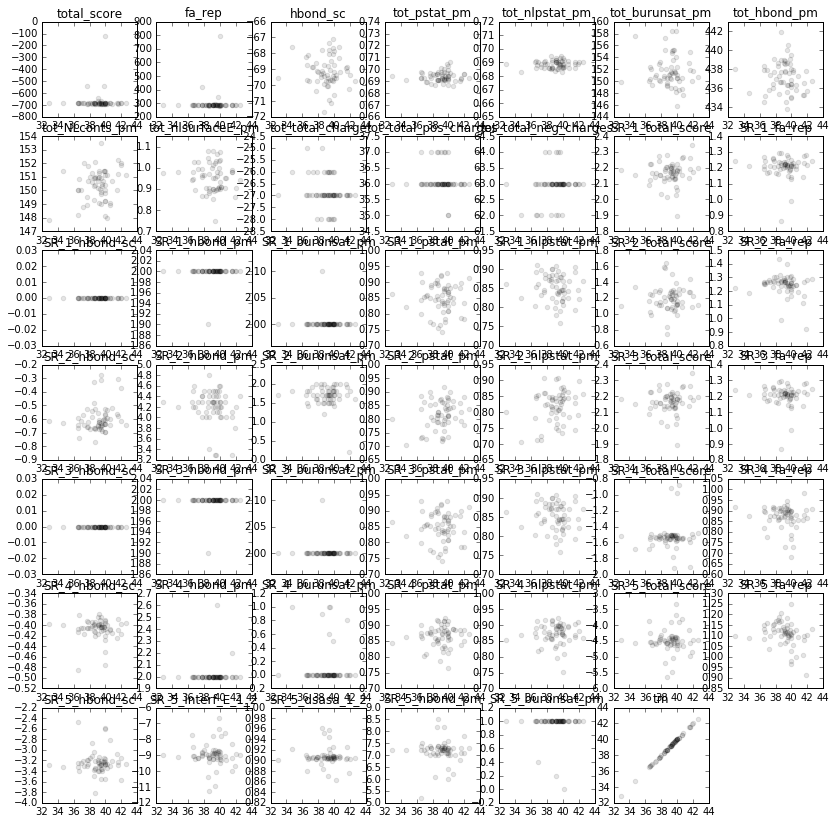

ValueError: max() arg is an empty sequence

In [39]:
# %matplotlib inline 
# import matplotlib.pyplot as plt 

plt.figure( figsize=( 14, 14 ) ) 

for i, feature in enumerate( df.columns ):
    plt.subplot( 7, 7, i + 1 ) 
    plt.scatter( df.tm, df[ feature ], c='k', alpha=0.1 ) #, c=df.expression, cmap='Blues', vmin=-0.5 ) 
    plt.title( feature ) 
    #plt.xticks( [ 0, 1 ], [ 0, 1 ] ) 

plt.show()
plt.tight_layout()

In [ ]:
# sequence-based view of features 
df.plot(subplots=True, style='.', figsize=(14,20))

In [ ]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df, alpha=0.2, figsize=(20, 20) ) 

In [ ]:
scl = preprocessing.MinMaxScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1:].as_matrix().ravel()

In [ ]:
scl = preprocessing.MinMaxScaler

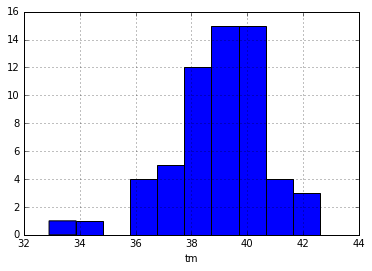

In [41]:
# distribution of predictors

df.tm.hist()
plt.xlabel('tm')

In [42]:
y

array([ 37.2,  38.7,  40. ,  34.7,  38. ,  39.9,  39.3,  39.6,  37.7,
        38.5,  39.4,  39.9,  38.6,  36.7,  40.2,  37.8,  39.2,  37.7,
        39.4,  41.6,  38.7,  39.8,  36.6,  40. ,  41.6,  40.2,  40.8,
        40.6,  42. ,  39.2,  36.6,  39.5,  39.7,  38.3,  36.9,  39.2,
        40. ,  39.2,  40. ,  39.5,  42.6,  32.9,  41.9,  39.9,  36.5,
        38.7,  38.7,  37.3,  39.1,  39. ,  39.1,  39.4,  41.5,  38.5,
        40. ,  39.6,  40.6,  37.8,  38.3,  39.8])

In [43]:
print X.shape
print y.shape

(60, 47)
(60,)


(-0.10969941354663477, 0.40406945389551219)

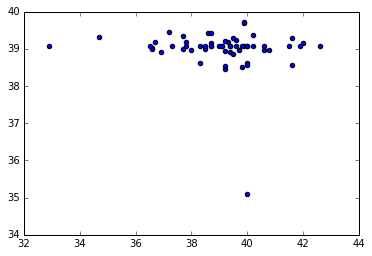

In [44]:
from sklearn.linear_model import ElasticNetCV

clf = ElasticNetCV(cv=10)
preds = cross_validation.cross_val_predict( clf, X, y ) 
plt.scatter( y, preds ) 

from scipy.stats import pearsonr

pearsonr( y, preds ) 

In [45]:
# Split the dataset in two equal parts to be used to train and test 3 classifiers below 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

In [47]:
pandas.tools.plotting??

### Begin the classifiers

In [ ]:
# random forest

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

In [ ]:
# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print classification_report( y_true, y_pred )

y_desc = clf.best_estimator_.named_steps['rf'].predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

In [ ]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

In [ ]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

### Results 

<table>
    <thead>
        <tr>
            <th>
                Feature set
            </th>
            <th>
                SVM
            </th>
            <th>
                Random forest
            </th>
            <th>
                Logit. regr.
            </th>

        </tr>
    </thead>
    <tbody>
        <tr>
            <td>FoldX</td>
            <td>FoldX</td>
            <td>FoldX</td>
            <td>FoldX</td>
        </tr>
    </tbody>
</table>